# Evaluate multiple models

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sys

import os
from os.path import join, basename
from glob import glob
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import plotly

from time import time
from tqdm import tqdm

import tensorflow as tf

import cv2

sys.path.insert(0, "C:\\Users\\N.Jabareen\\Projects\\data\\data_utils")

%aimport statistics
%aimport visualization
%aimport prediction_utils

import detection_data
from tf_record_utils import tf_record_loading as loader
from data_transformations import image_slice_utils as slicer

In [3]:
%aimport data_transformations.image_slice_utils

In [4]:
%aimport

Modules to reload:
data_transformations.image_slice_utils prediction_utils statistics visualization

Modules to skip:



## Set paths

In [5]:
GRAPH_DIR = "D:\\Nabil_object_detection\\models\\graph_imgSize_vs_bboxSize"
TEST_DIR = "D:\\Nabil_object_detection\\val"

In [6]:
# Paths for brightfield
FASTER_RCNN_10x_PATHS = glob(join(GRAPH_DIR, "faster_rcnn*10x*"))
SSD_10x_PATHS = glob(join(GRAPH_DIR, "ssd*10x*"))
TEST_DIR_10x_PATHS = glob(join(TEST_DIR, "10x*.tfrecord"))

# Paths for lensfree
FASTER_RCNN_z00_PATHS = glob(join(GRAPH_DIR, "faster_rcnn*z00*"))
SSD_z00_PATHS = glob(join(GRAPH_DIR, "ssd*z00*"))
TEST_DIR_z00_PATHS = glob(join(TEST_DIR, "z00*.tfrecord"))

In [7]:
TEST_DIR_z00_PATHS

['D:\\Nabil_object_detection\\val\\z00_tiles0_bboxes20.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles0_bboxes40.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles0_bboxes60.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles4_bboxes20.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles4_bboxes40.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles4_bboxes60.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles8_bboxes20.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles8_bboxes40.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles8_bboxes60.tfrecord']

In [8]:
# Brightfield paths
BF_BBOX20_PATHS = glob(join(GRAPH_DIR, "*10x*bboxes20"))
BF_BBOX20_TEST_PATHS = glob(join(TEST_DIR, "*10x*bboxes20.tfrecord"))

BF_BBOX40_PATHS = glob(join(GRAPH_DIR, "*10x*bboxes40"))
BF_BBOX40_TEST_PATHS = glob(join(TEST_DIR, "*10x*bboxes40.tfrecord"))

BF_BBOX60_PATHS = glob(join(GRAPH_DIR, "*10x*bboxes60"))
BF_BBOX60_TEST_PATHS = glob(join(TEST_DIR, "*10x*bboxes60.tfrecord"))

# Lensfree paths
LF_BBOX20_PATHS = glob(join(GRAPH_DIR, "*z00*bboxes20"))
LF_BBOX20_TEST_PATHS = glob(join(TEST_DIR, "*z00*bboxes20.tfrecord"))

LF_BBOX40_PATHS = glob(join(GRAPH_DIR, "*z00*bboxes40"))
LF_BBOX40_TEST_PATHS = glob(join(TEST_DIR, "*z00*bboxes40.tfrecord"))

LF_BBOX60_PATHS = glob(join(GRAPH_DIR, "*z00*bboxes60"))
LF_BBOX60_TEST_PATHS = glob(join(TEST_DIR, "*z00*bboxes60.tfrecord"))

## Predictions

In [9]:
def get_predictions(model_paths, data_paths):
    
    annotation = next(loader.tf_dataset_generator(data_paths[0]))
    image = annotation.get("image")
    gt_bboxes = annotation.get("bboxes")
    
    predictions = {}
    for i, model_path in enumerate(model_paths):

        # Parse model configs
        model_path_configuration = basename(model_path).split("_tiles")[1]
        tiles, bbox_size = model_path_configuration.split("_bboxes")

        # Load model and data
        print("Loading model:", basename(model_path))
        model = prediction_utils.load_model(model_path)

        # Predict on image
        print("Predict with tiles:", tiles)
        prediction, confidence = prediction_utils.predict_on_tiled_image(model, image, tiles=int(tiles))

        #Save prediction
        predictions[basename(model_path)] = {"prediction": prediction, "confidence": confidence}
        
    return predictions, annotation

In [10]:
# query_predictions, query_annotations = get_predictions(LF_BBOX60_PATHS, LF_BBOX60_TEST_PATHS)

## Visualiye predictions

In [11]:
def show_predictions(prediction, annotation, conf_threshold=0.5):
    
    pred = prediction.get("prediction")
    conf = prediction.get("confidence")
    
    image = annotation.get("image")
    gt_bboxes = annotation.get("bboxes")
    
    visualization.plot_bboxes_on_image(image, gt_bboxes, pred[conf >= conf_threshold])

In [12]:
# for model, prediction in query_predictions.items():
#     print(model)
#     show_predictions(prediction, query_annotations, conf_threshold=0.5)

# Precision-Recall curves

In [13]:
def convert_predictions(preds):
    
    converted_preds = {}
    
    for name, pred in preds.items():
        
        pred_yx = np.apply_along_axis(detection_data.bbox_xy1xy2_to_yx1yx2, 1, pred.get("prediction"))
        pred_yx_sorted = pred_yx[np.argsort(pred.get("confidence"))[::-1]]
        
        converted_preds[name] = pred_yx_sorted
    
    return converted_preds

In [14]:
# query_predictions_converted = convert_predictions(query_predictions)

In [15]:
# fig = visualization.plot_precision_recall_curves(gt4_yx,
#                                            query_predictions_converted.get("faster_rcnn_resnet101_coco_z00_tiles0_bboxes60"),
#                                            query_predictions_converted.get("faster_rcnn_resnet101_coco_z00_tiles4_bboxes60"),
#                                            query_predictions_converted.get("faster_rcnn_resnet101_coco_z00_tiles8_bboxes60"),
#                                            query_predictions_converted.get("ssd_resnet50_v1_fpn_z00_tiles0_bboxes60"),
#                                            query_predictions_converted.get("ssd_resnet50_v1_fpn_z00_tiles4_bboxes60"),
#                                            query_predictions_converted.get("ssd_resnet50_v1_fpn_z00_tiles8_bboxes60"),
#                                                  title="Lensfree - BBox size 60px",
#                                            names=["Faster_Tiles0", "Faster_Tiles4", "Faster_Tiles8",
#                                                  "SSD_Tiles0", "SSD_Tiles4", "SSD_Tiles8"])

In [16]:
# # Save plot
# plot_path = "C:\\Users\\N.Jabareen\\presentations\\precision_recall_lf_bbox60.html"

# if not os.path.isfile(plot_path):
#     plotly.offline.plot(fig, filename=plot_path)
# else:
#     print("Plot already exists!!")

## Clustered cells

In [60]:
from scipy.spatial import distance

from statistics import evaluate_distance_cutoffs
from visualization import plotly_precision_recall_slider, draw_bboxes_on_image

### Get model, annotation and prediction

In [18]:
lf_model_path = LF_BBOX40_PATHS[3]
lf_data_path = TEST_DIR_z00_PATHS[1]

bf_model_path = BF_BBOX40_PATHS[3]
bf_data_path = TEST_DIR_10x_PATHS[1]

print(f"LF CONFIGS:\nModel: {basename(lf_model_path)}\nData: {basename(lf_data_path)}\n")
print(f"BF CONFIGS:\nModel: {basename(bf_model_path)}\nData: {basename(bf_data_path)}")

LF CONFIGS:
Model: ssd_resnet50_v1_fpn_z00_tiles0_bboxes40
Data: z00_tiles0_bboxes40.tfrecord

BF CONFIGS:
Model: ssd_resnet50_v1_fpn_10x_tiles0_bboxes40
Data: 10x_tiles0_bboxes40.tfrecord


In [20]:
lf_model = prediction_utils.load_model(lf_model_path)
bf_model = prediction_utils.load_model(bf_model_path)

lf_annotation = next(loader.tf_dataset_generator(lf_data_path))
bf_annotation = next(loader.tf_dataset_generator(bf_data_path))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [21]:
lf_image = lf_annotation.get("image")
lf_gt_bboxes = lf_annotation.get("bboxes")

bf_image = bf_annotation.get("image")
bf_gt_bboxes = bf_annotation.get("bboxes")

In [22]:
lf_prediction = prediction_utils.run_inference_for_single_image(lf_model, lf_image)
bf_prediction = prediction_utils.run_inference_for_single_image(bf_model, bf_image)

In [23]:
lf_pred_bboxes, lf_pred_conf = lf_prediction.get("detection_boxes"), lf_prediction.get("detection_scores")
bf_pred_bboxes, bf_pred_conf = bf_prediction.get("detection_boxes"), bf_prediction.get("detection_scores")

### Plot predicted points and GT on image

In [24]:
conf_thresh = 0.5

In [25]:
lf_pred_points = statistics.boxes_to_center_points(lf_pred_bboxes[lf_pred_conf >= conf_thresh])
lf_gt_points = statistics.boxes_to_center_points(lf_gt_bboxes)

bf_pred_points = statistics.boxes_to_center_points(bf_pred_bboxes[bf_pred_conf >= conf_thresh])
bf_gt_points = statistics.boxes_to_center_points(bf_gt_bboxes)

In [26]:
lf_img = visualization.draw_circles_on_image(lf_image, lf_gt_points)
lf_img = visualization.draw_circles_on_image(lf_img, lf_pred_points, default_color=(0,0,255))

bf_img = visualization.draw_circles_on_image(bf_image, bf_gt_points)
bf_img = visualization.draw_circles_on_image(bf_img, bf_pred_points, default_color=(0,0,255))

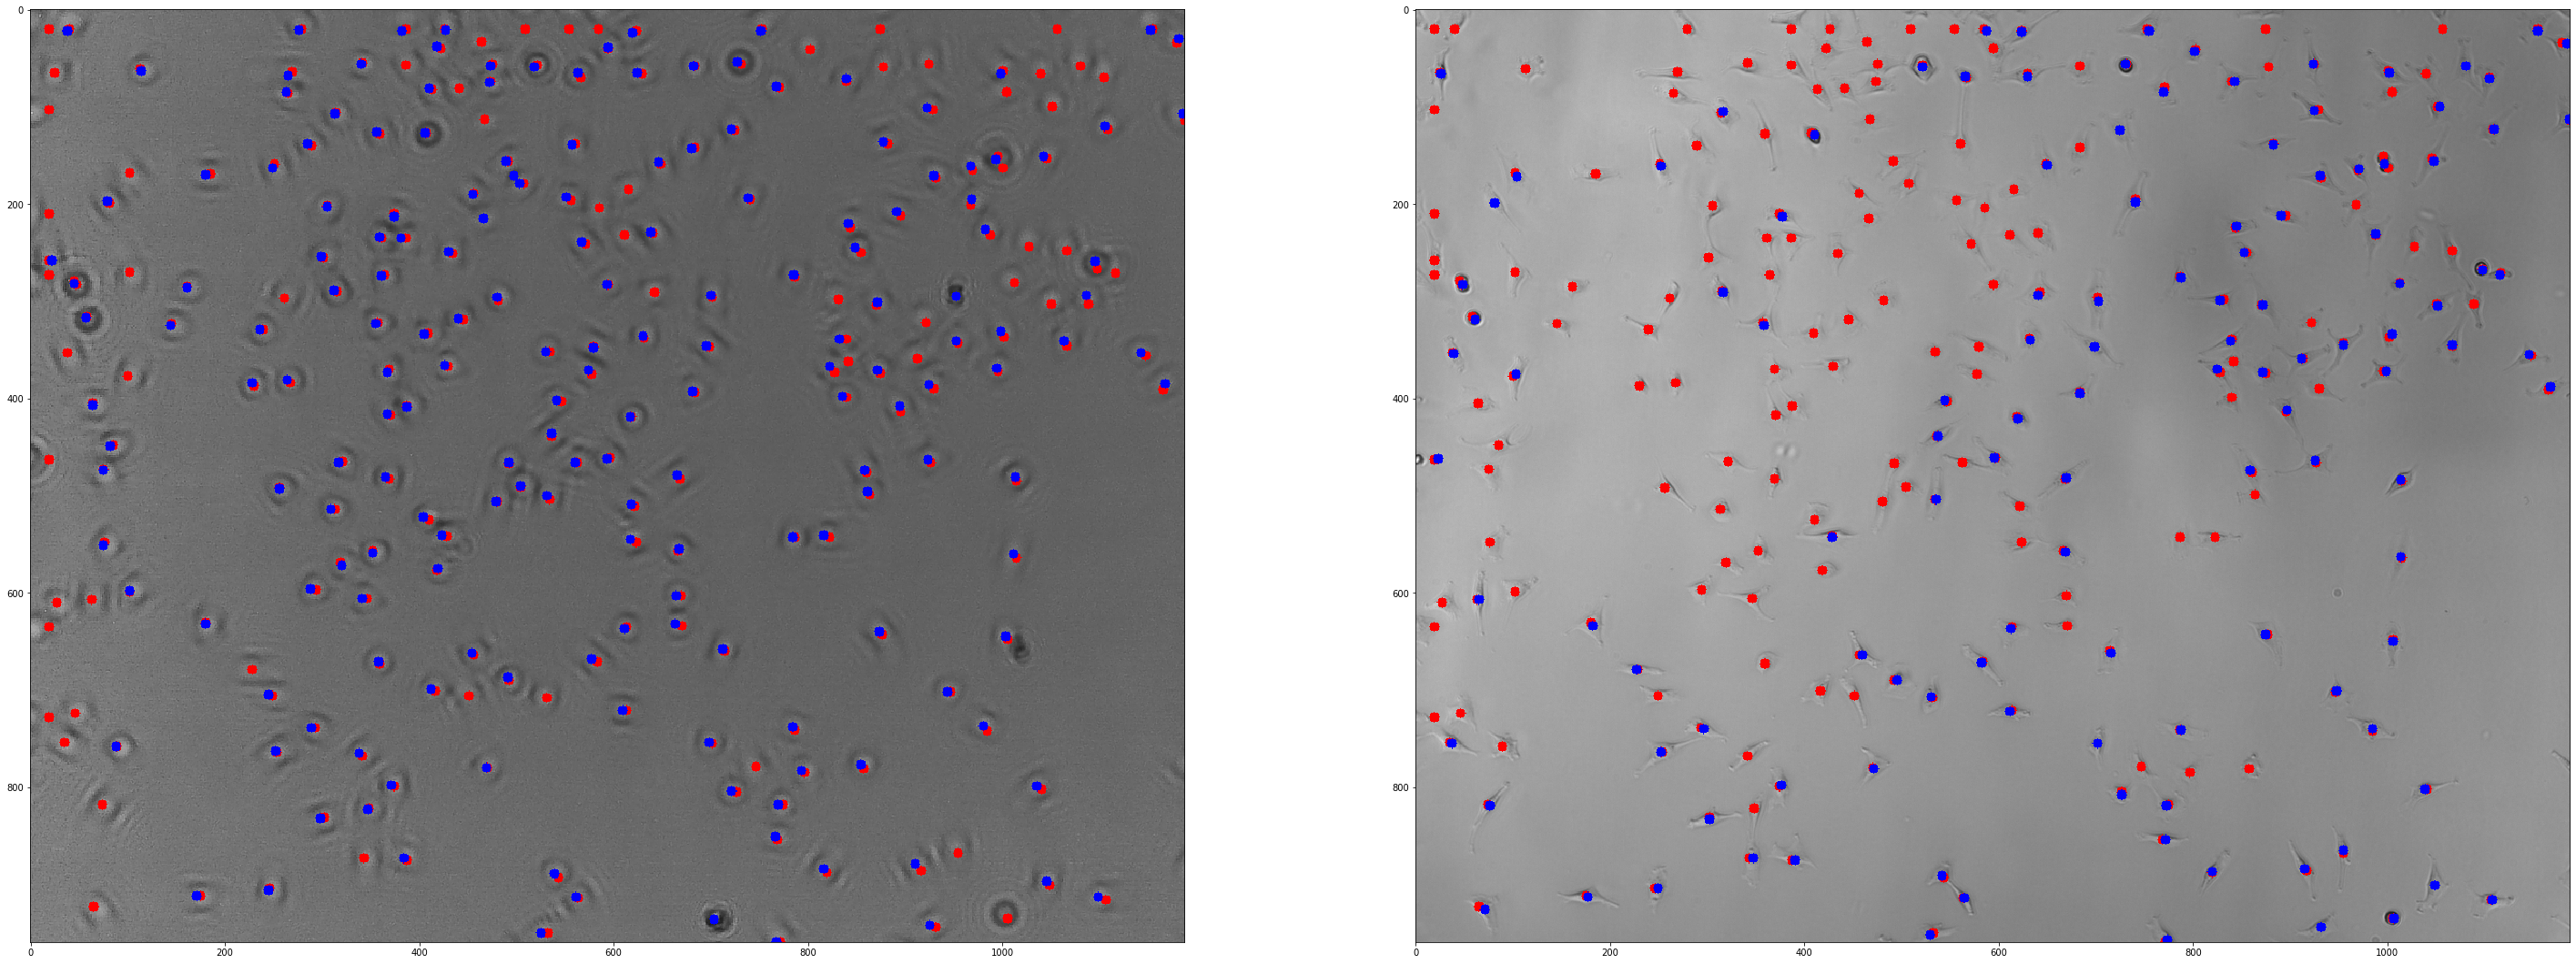

In [497]:
plt.figure(figsize=(50, 50))
plt.subplot(121)
plt.imshow(lf_img)
plt.subplot(122)
plt.imshow(bf_img)
plt.show()

### Evaluate model with points where distance of $k$ nearest neighbours $<threshold$ 

In [27]:
distance_thresholds = np.linspace(40, 130, 5)

In [49]:
lf_distnaces = distance.cdist(lf_gt_points, lf_pred_points)
k_nn = statistics.find_n_closest_points(lf_distnaces, 3)
gt_mean_dist = np.mean(k_nn, axis=1)

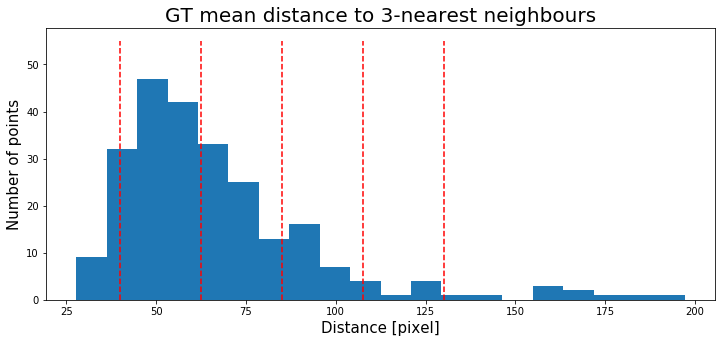

In [50]:
# GT distances with thresholds as vertival lines

plt.figure(figsize=(12,5))
plt.title("GT mean distance to 3-nearest neighbours", fontsize=20)
plt.xlabel("Distance [pixel]", fontsize=15)
plt.ylabel("Number of points", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.hist(gt_mean_dist, bins=20)
# plt.vlines(np.mean(gt_mean_dist), 0, 60, colors="red", linewidths=5)
plt.vlines(distance_thresholds, 0, 55, linestyles="dashed", colors="red")
plt.show()

### Slider show of distance cutoffs

In [53]:
gt_dist_colors = visualization.values_to_rgb(gt_mean_dist)

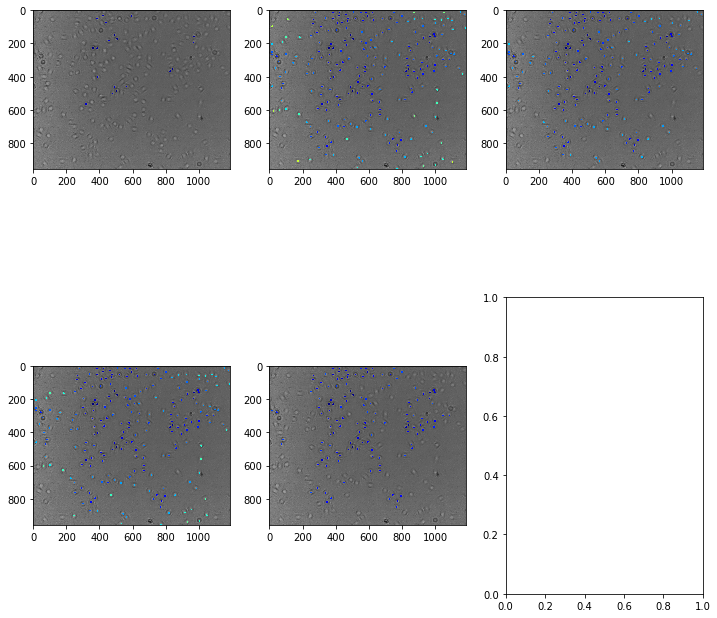

In [56]:
dist_images = []

fig, axs = plt.subplots(nrows=2, ncols=3)

for i, dt in enumerate(distance_thresholds):
    
    gt_dist_colors_np = np.array(gt_dist_colors)
    
    valid_colors = gt_dist_colors_np[gt_mean_dist <= dt]
    valid_points = lf_gt_points[gt_mean_dist <= dt]

    img = visualization.draw_circles_on_image(lf_image, valid_points, point_colors=valid_colors.tolist())
    dist_images.append(img)
    
    row = i%2
    col = i%3
    axs[row, col].imshow(img)
    
fig.set_size_inches((12, 12))

In [471]:
# fig = visualization.plotly_image_slider(dist_images, distance_thresholds)

### Precision recall with distance cutoff

In [143]:
conf_thresh = 0.5
lf_data_generator = loader.tf_dataset_generator(lf_data_path)

In [144]:
for lf_annotation in lf_data_generator:

    lf_image = lf_annotation.get("image")
    lf_gt_bboxes = lf_annotation.get("bboxes")

    lf_prediction = prediction_utils.run_inference_for_single_image(lf_model, lf_image)
    lf_pred_bboxes, lf_pred_conf = lf_prediction.get("detection_boxes"), lf_prediction.get("detection_scores")

    lf_pred_points = statistics.boxes_to_center_points(lf_pred_bboxes[lf_pred_conf >= conf_thresh])
    lf_gt_points = statistics.boxes_to_center_points(lf_gt_bboxes)

    lf_knn_stats = evaluate_distance_cutoffs(lf_pred_bboxes, lf_gt_bboxes, distance_thresholds, image=lf_image)
    fig = visualization.plotly_image_slider(lf_knn_stats.get("images"), distance_thresholds)

    name = lf_annotation.get("name").decode("utf-8").split("val")[1].split(".")[0].replace("\\", "")
    plotly.offline.plot(fig, filename=f"C:\\Users\\N.Jabareen\\presentations\\val_set_ssd_prediction\\{name}.html")
    

In [96]:
lf_knn_stats = evaluate_distance_cutoffs(lf_pred_bboxes, lf_gt_bboxes, distance_thresholds, image=lf_image)
# bf_knn_stats = evaluate_distance_cutoffs(bf_pred_bboxes, bf_gt_bboxes, distance_thresholds, image=bf_image)

In [97]:
lf_pre_rec = plotly_precision_recall_slider(lf_knn_stats.get("precisions"), lf_knn_stats.get("recalls"), distance_thresholds)
bf_pre_rec = plotly_precision_recall_slider(bf_knn_stats.get("precisions"), bf_knn_stats.get("recalls"), distance_thresholds)

In [98]:
fig = visualization.plotly_image_slider(lf_knn_stats.get("images"), distance_thresholds)

In [99]:
plotly.offline.plot(fig, filename="C:\\Users\\N.Jabareen\\presentations\\test.html")

'C:\\Users\\N.Jabareen\\presentations\\test.html'

In [508]:
plotly.offline.plot(lf_pre_rec, filename="C:\\Users\\N.Jabareen\\presentations\\test2.html")
plotly.offline.plot(bf_pre_rec, filename="C:\\Users\\N.Jabareen\\presentations\\test3.html")

'C:\\Users\\N.Jabareen\\presentations\\test3.html'